In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import iSDR_cython as ciSDR
np.random.seed(12)

# Define sensor and source space

In [2]:
n_t = 200
n_c, n_s = 3,3
np.random.seed(40)
G = np.abs(np.random.normal(0,1,(n_c, n_s)))
J = np.zeros((n_s, n_t))
J[:, 0] = [10, 0.1, 0]
A = np.array([[0.9,-0.4,0], [0.25, 0.97,0],[0,0,0]])
for i in range(J.shape[-1]-1):
    J[:, i+1] = np.dot(A, J[:, i])



# Ground truth

(0, 200)

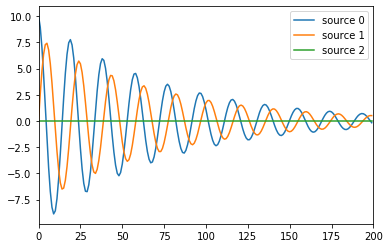

In [3]:
plt.plot(J.T)
plt.legend(['source %s'%s for s in range(n_s)])
plt.xlim(0, n_t)

# Define the structural connectivity

In [4]:
SC = np.array([[1,1,1], [1,1,0],[0,1,1]])
print( SC)

[[1 1 1]
 [1 1 0]
 [0 1 1]]


# Example 1: iSDR order 1

## Generate EEG/MEG data

In [5]:
m_p = 1
M = np.dot(G, J[:, m_p:])

## Run ISDR

In [6]:
cl = ciSDR.linear_model.iSDR(l21_ratio=0.1, la=1e-3)
cl.solver(G, M, SC, nbr_iter=10, model_p=1, A=np.eye(n_s), method='lasso')
R = cl.coef_

## Get eigenvalues of MVAR model

In [7]:
cl.get_phi()
cl.eigs

,real,imag
eig,,
eig_0,0.937373,0.314642
eig_1,0.937373,-0.314642


## Plot effective connectivity

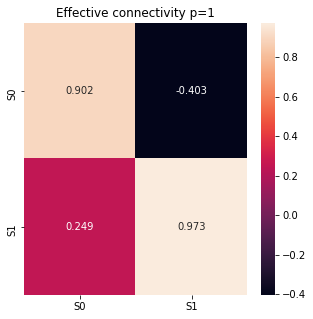

In [8]:
cl.plot_effective()

## Reconstruct the brain activation

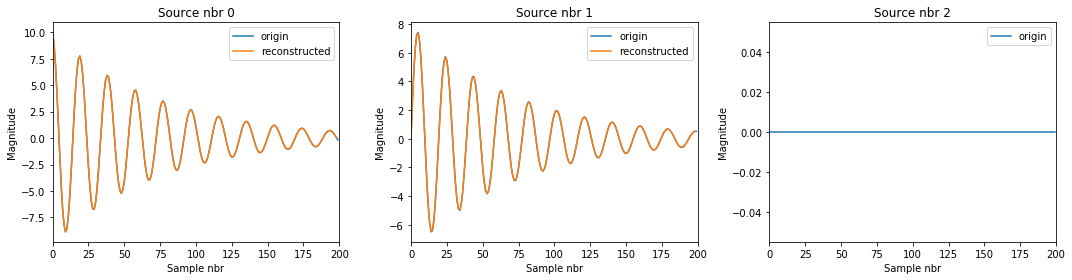

In [9]:
plt.figure(figsize=(15,4))
for i in range(n_s):
    plt.subplot(1,n_s, i+1)
    plt.plot(J[i, :], label='origin')
    if i < R.shape[0]:
        plt.plot(R[i, m_p-1:], label='reconstructed')
    plt.title('Source nbr %s'%i)
    plt.xlim(0, J.shape[1])
    plt.xlabel('Sample nbr')
    plt.ylabel('Magnitude')
    plt.legend()
plt.tight_layout()

## Reconstruct the brain activation using the estimated MVAR model

In [10]:
for i in range(m_p, n_t - m_p):
    R[:, i] = 0
    x = R.shape[0]
    for j in range(m_p):
        R[:, i] += np.dot(cl.Acoef_[:, j*x:(j+1)*x], R[:, i - m_p + j]) 

(0, 200)

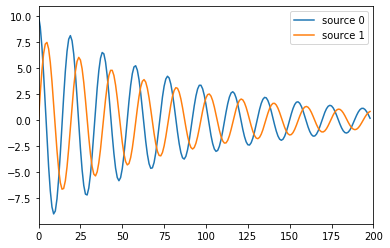

In [11]:
plt.plot(R.T)
plt.legend(['source %s'%s for s in cl.active_set[-1]])
plt.xlim(0, n_t)

# Example 2: iSDR order 3

## Initialize MVAR model

In [12]:
m_p = 3
Atmp = np.zeros((n_s, n_s*m_p))
Atmp[:, -n_s:] = np.eye(n_s)

## Run iSDR

In [13]:
cl = ciSDR.linear_model.iSDR(l21_ratio=0.1, la=1e-3)
cl.solver(G, M, SC, nbr_iter=10, model_p=m_p, A=Atmp, method='lasso')
R = cl.coef_

## Compute eigenvalues of MVAR model

In [14]:
cl.get_phi()
cl.eigs

,real,imag
eig,,
eig_0,0.935803,0.314422
eig_1,0.935803,-0.314422
eig_2,-0.723980,0.629955
eig_3,-0.723980,-0.629955
eig_4,-0.194797,0.938604
eig_5,-0.194797,-0.938604


## Plot effective connectivity

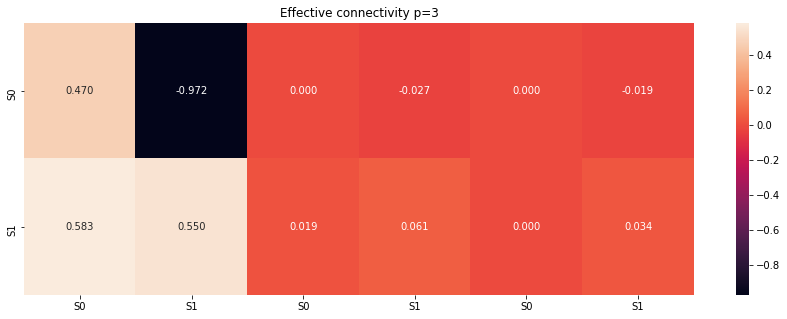

In [15]:
cl.plot_effective()

## Reconstruct the brain activation

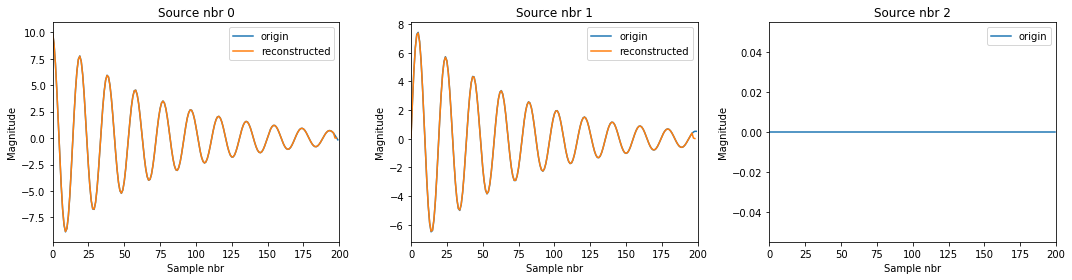

In [16]:
plt.figure(figsize=(15,4))
for i in range(n_s):
    plt.subplot(1,n_s, i+1)
    plt.plot(J[i, :], label='origin')
    if i < R.shape[0]:
        plt.plot(R[i, m_p - 1:], label='reconstructed')
    plt.title('Source nbr %s'%i)
    plt.xlim(0, J.shape[1])
    plt.xlabel('Sample nbr')
    plt.ylabel('Magnitude')
    plt.legend()
plt.tight_layout()

## Reconstruct the brain activation using the estimated MVAR model

In [17]:
for i in range(m_p, R.shape[1]):
    R[:, i] = 0
    x = R.shape[0]
    for j in range(m_p):
        R[:, i] += np.dot(cl.Acoef_[:, j*x:(j+1)*x], R[:, i - m_p + j]) 

(0, 200)

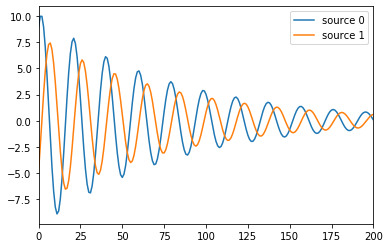

In [18]:
plt.plot(R.T)
plt.legend(['source %s'%s for s in cl.active_set[-1]])
plt.xlim(0, n_t)

# Cross-validation iSDR

## Load iSDRcv

In [19]:
from iSDR_cython import linear_model

In [20]:
clf = linear_model.iSDRcv(l21_values=[10**-i for i in range(-1, 6, 1)],
                          la_values=[10**-i for i in range(-1, 5,1)], model_p=[1,2,3],
                          method=['lasso', 'ridge'])

## Created random folder

In [21]:
clf.foldername

'/tmp/tmp_860307ef-d8a0-489b-b2d0-a28a1eea7df5'

## Run grid cross validation

In [22]:
clf.run(G, M, SC)

## Results

In [23]:
df = clf.results

In [24]:
df.head()

,rms,nbr,S_prior,A_prior,ls_reg,la_reg,reg_method,p,Obj
0,1473.850625,2,922.299097,2.592852,1.0000,0.0001,ridge,1,2396.149982
1,133.371840,2,28.363607,2.041304,10.0000,1.0000,lasso,2,419.049215
2,123.207710,0,0.000000,0.000000,1.0000,0.0001,ridge,3,123.207710
3,40.306867,2,70.944433,2.512487,0.0001,10.0000,ridge,1,65.438828
4,401.553238,2,276.219533,2.707698,1.0000,0.0100,ridge,2,677.799849


## Parameters resulting to smallest Obj

In [50]:
x  = df[df.Obj == df.Obj.min()]

In [51]:
x

,rms,nbr,S_prior,A_prior,ls_reg,la_reg,reg_method,p,Obj
130,39.625545,2,77.345883,2.520007,0.0001,0.0001,ridge,1,39.633531


## Reconstruct with optimal parameters

In [52]:
cl = ciSDR.linear_model.iSDR(l21_ratio=x.ls_reg.values[0], la=x.la_reg.values[0])
cl.solver(G, M, SC, nbr_iter=10, model_p=x.p.values[0], A=np.eye(n_s), method=x.reg_method.values[0])
R = cl.coef_

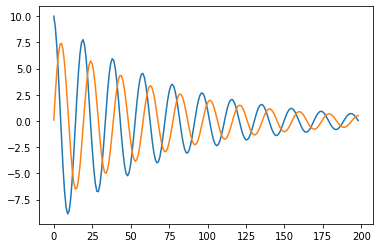

In [53]:
plt.plot(cl.coef_.T)

## Reconstructed effective connectivity

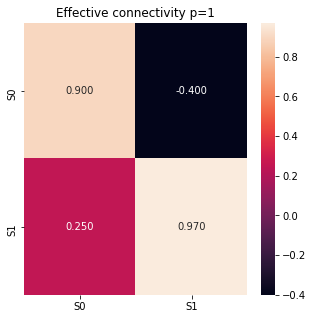

In [54]:
cl.plot_effective()

## Reconstructed dynamics

In [55]:
cl.get_phi()
cl.eigs

,real,imag
eig,,
eig_0,0.935002,0.314285
eig_1,0.935002,-0.314285
